In [3]:
import sys
sys.path.append('../../build')
import numpy as np
import libry as ry
import math
import time
import cv2 as cv
import matplotlib.pyplot as plt
import random


from mpl_toolkits import mplot3d
from scipy.spatial.transform import Rotation as R
#obj_size is not used but can be easier
#colors is the array of different colors of flashlights

obj_size=[0.2 ,0.05]
arm_centers=["L_gripperCenter","R_gripperCenter"]
colors=["red","blue"]
#we segment red and bluepixels by masking here
def _segment_redpixels(rgb,color="red"):
    """
    Compute a binary mask of red pixels
    """
    rgb = cv.cvtColor(rgb, cv.COLOR_BGR2RGB)
    hsv = cv.cvtColor(rgb, cv.COLOR_BGR2HSV)
    
    if color=="red":
        mask1 = cv.inRange(hsv, (0, 120, 70), (10, 255, 255))
        mask2 = cv.inRange(hsv, (170, 120, 70), (180, 255, 255))

    else:
        mask1 = cv.inRange(hsv, (120, 150, 50), (130, 255, 255))
        #mask2 = cv.inRange(hsv, (20, 220, 70), (100, 255, 100))
    if  "mask2" in locals():   
        mask = mask1 + mask2
    else:
        mask=mask1
    # find contours
    contours = cv.findContours(mask, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    if len(contours) > 0:
        # find largest contour
        largest, idx = 0., None
        for i, c in enumerate(contours):
            if c.shape[0] < 10:
                continue
            if cv.contourArea(c) > largest:
                largest = cv.contourArea(c)
                idx = i

        if idx is not None:
            # fill contours line in rgb image
            mask = cv.drawContours(
                np.zeros_like(mask), contours, idx, 255, cv.FILLED)

            # uncomment the followings to see contours line in rgb image
            import matplotlib.pyplot as plt
            rgb = cv.drawContours(rgb, contours, idx, (0,255,0), 3)
            plt.figure()
            plt.imshow(rgb)
            plt.show()

    return mask

#then get the depth data and use it as pointcloud
def _image_pointcloud(depth, rgb, mask):
    """
    Compute point cloud in pixel coordinate
    """
    mask_pixels = np.where(mask > 0)
    pointcloud = np.zeros((mask_pixels[0].shape[0], 3))
    pointcloud[:, 0] = mask_pixels[1]  # x pixels
    pointcloud[:, 1] = mask_pixels[0]  # y pixels
    pointcloud[:, 2] = depth[mask_pixels[0], mask_pixels[1]]

    masked_rgb = rgb[mask_pixels]
    return pointcloud, masked_rgb

def _meter_pointcloud(pixel_points, cameraFrame, fxfypxpy):
    """
    Args:
        pixel_points: pointcloud in pixel coordinate
        cameraFrame: rai camera frame
        fxfypxpy: camera intrinsic
    Returns
        points: (N, 3) pointcloud in world frame
        rel_points: (N, 3) pointcloud in camera frame
    """
    x = pixel_points[:, 0]
    y = pixel_points[:, 1]
    d = pixel_points[:, 2]
    rel_points = np.zeros(np.shape(pixel_points))
    rel_points[:, 0] = d * (x - fxfypxpy[2]) / fxfypxpy[0]
    rel_points[:, 1] = -d * (y - fxfypxpy[3]) / fxfypxpy[1]
    rel_points[:, 2] = -d

    cam_rot = cameraFrame.getRotationMatrix()
    cam_trans = cameraFrame.getPosition()
    points = rel_points @ cam_rot.T + cam_trans

    return points, rel_points  # (num_points, 3)

#this function connects the functions above
def find_redpixels(rgb, depth, cameraFrame, fxfypxpy, color="red"):
    mask = _segment_redpixels(rgb,color)
    pixel_points, masked_rgb = _image_pointcloud(depth, rgb, mask)
    obj_points, rel_points = _meter_pointcloud(
        pixel_points, cameraFrame, fxfypxpy)
    return obj_points, rel_points, masked_rgb

#pca for orientation estimation
def simplePCA(arr):
    '''
    :param arr: input array of shape shape[N,M]
    :return:
        mean - center of the multidimensional data,
        eigenvalues - scale,
        eigenvectors - direction
    '''

    # calculate mean
    m = np.mean(arr, axis=0)
    
    # center data
    arrm = arr-m
    Cov = np.cov(arrm.T)
    eigval, eigvect = np.linalg.eig(Cov.T)

    # return mean, eigenvalues, eigenvectors
    return m, eigval, eigvect

name=0
#this function is the function that creates the dots on the wall depending on the orientation of the flashlight

def CreateLightObject(capsule,position,basepointstr):
    global name
    for targets in position:
        tempObj=RealWorld.frame(capsule)
        #location=RealWorld.frame(capsule).getPosition()
        temptargetname="light_target"+str(name)
        temptarget=RealWorld.addFrame(temptargetname)
        temptarget.setPosition(targets)
        object_center_distance = RealWorld.feature(ry.FS.poseDiff, [temptargetname,capsule])
        long=object_center_distance.eval(RealWorld)[0][0:3]
        


        komo = RealWorld.komo_path(1, 40, 2., True)
        komo.addObjective([1.], ry.FS.positionRel, [
                                      capsule, basepointstr], ry.OT.eq, 1e2)

        komo.addObjective([1.], ry.FS.vectorZ, [
                              capsule], ry.OT.eq, 1e1, long )

        komo.optimize()
        S.setMoveto(komo.getPath_qOrg(), .5)
        for t in range(50):
            time.sleep(tau)
            S.step([], tau, ry.ControlMode.spline)
        tempObj=RealWorld.frame(capsule)
        y_caps=tempObj.getPosition()[1]
        direction=tempObj.getRotationMatrix()[:,2]
        coef_of_distance=((y_wall-y_caps)/direction[1])
        dotname="cylinder"+str(x)
        pos_diff=coef_of_distance*direction
        cylinderspot=tempObj.getPosition()+pos_diff
        tmpCylinderRW= RealWorld.addFrame(dotname,"",'X:<d(90 1 0 0)>')
        tmpCylinderRW.setShape(ry.ST.cylinder,[0.12,0.02])
        tmpCylinderRW.setPosition(cylinderspot)
        if capsule=="capsule1":
            tmpCylinderRW.setColor([255,0,0])
        else:
            tmpCylinderRW.setColor([0,0,255])
        name +=1
    return 0

#this function is used to get the orientation and location and select which arm will be used to grasp(also does drop and grab)
def select_arm(colour):
    [rgb, depth] = S.getImageAndDepth()
    obj_points, rel_points, masked_rgb = find_redpixels(
        rgb, depth, cameraFrame, fxfypxpy,color=colour)
    m, eigva, eigve = simplePCA(obj_points)
    eigve = eigve * eigva * 0.5
    long=eigve[0,:]
    start_vec=[0,1,0]
    crossed=np.cross(long,start_vec)
    cross_norm=crossed/np.linalg.norm(crossed)
    theta=np.arccos(np.dot(long/np.linalg.norm(long),start_vec/np.linalg.norm(start_vec)))
    print(crossed,cross_norm,theta)
    A=np.array([[0,-cross_norm[2],cross_norm[1]],
       [cross_norm[2],0,-cross_norm[0]],
       [-cross_norm[1], cross_norm[0],0]])

    rotation=np.eye(3)+np.sin(theta)*A+(1-np.cos(theta))*A@A
    r = R.from_matrix(rotation)
    quat=r.as_quat()
    shape=ry.ST.capsule
    capsulestr="object"+colour
    tmpObjRW= RealWorld.addFrame(capsulestr)
    tmpObjRW.setShape(shape, obj_size)
    tmpObjRW.setPosition([m[0],m[1],m[2]-0.015])
    tmpObjRW.setQuaternion(quat)
    tmpObjRW.setColor([0,0,0,0])
    smallest_difference, idx = 100000., None
    for arm in arm_centers:
        arm_and_object_center_distance = RealWorld.feature(ry.FS.distance, [arm, capsulestr])
        arm_and_object_center_distance=-arm_and_object_center_distance.eval(RealWorld)[0][0]
        if arm_and_object_center_distance < smallest_difference:
                smallest_difference = arm_and_object_center_distance
                selected_arm=arm

        controlstring=selected_arm.replace('Center','')
        if S.getGripperIsGrasping(controlstring):
            S.openGripper(controlstring, speed=1.)
            
    return selected_arm,capsulestr

#here we define the config, simulation, camera parameters
RealWorld = ry.Config()
RealWorld.addFile("../../scenarios/pandasTable.g")
flashlight=RealWorld.addFile("../../scenarios/firstgtry.g")
holding_part_of_flashlight= RealWorld.frame("capsule1")
holding_part_of_flashlight.setContact(1)
holding_part_of_flashlight.setMass(1)
#holding_part_of_flashlight.setPosition([random_array[1],0.74,random_array[2]])
lightbox= RealWorld.frame("box1")
lightbox.setContact(1)
lightbox.setMass(1)
holding_part_of_flashlight2= RealWorld.frame("capsule2")
holding_part_of_flashlight2.setContact(1)
holding_part_of_flashlight2.setMass(1)
#holding_part_of_flashlight.setPosition([random_array[3],0.74,random_array[4]])
# instantiate the simulation
S = RealWorld.simulation(ry.SimulatorEngine.bullet, True)
S.addSensor("camera")
q0 = S.get_q()
cameraFrame = RealWorld.frame("camera")
# Intrinsic Params
camInfo = cameraFrame.info()
f = camInfo['focalLength']
f = f * camInfo['height']
fxfypxpy = [f, f, camInfo['width'] / 2, camInfo['height'] / 2]
points = []
tau = .01

view=True
#we start the simulation here
for i in range(0, 50):
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
#grasping by KOMO done here

def grasp_part(selected_arm,capsulestr):
    gripping = False
    grasped = False
    for t in range(3000):
        time.sleep(tau)

        # grab sensor readings from the simulation
        q = S.get_q()
        RealWorld.setJointState(q)  # set your robot model to match the real q
        if (not gripping and S.getTimeToMove() <= 0):
            # Only solve a komo problem if I have already executed the last spline

            y, J = RealWorld.evalFeature(ry.FS.positionDiff, [selected_arm, capsulestr])
            komo = RealWorld.komo_path(1, 40, 2., True)
            komo.addObjective([.8, 1], ry.FS.positionDiff, [
                                      selected_arm, capsulestr], ry.OT.sos, 1e2)
            komo.addObjective(
                        [.8,1], ry.FS.positionDiff, [
                            selected_arm, capsulestr], ry.OT.eq, 1e3)

                    # we want the gripper to look at the object
            komo.addObjective([.5, 1.], ry.FS.positionRel, [
                                  capsulestr, selected_arm], ry.OT.sos, 1e2 * np.array([1, 0, 0]))

            komo.addObjective([.5, 1.], ry.FS.positionRel, [
                                      capsulestr, selected_arm], ry.OT.sos, 1e2 * np.array([0, 1, 0]))
                    # collision avoidance
            komo.addObjective(
                        [],
                        ry.FS.accumulatedCollisions, [],
                        ry.OT.eq, 1e1 )
            komo.optimize()
            S.setMoveto(komo.getPath_qOrg(), .5)
                # set your robot model to match the real q
            RealWorld.setJointState(S.get_q())
        elif gripping:
            S.setMoveto(S.get_q(),tau, append=False)
        y, J = RealWorld.evalFeature(ry.FS.positionRel, [selected_arm, capsulestr])
        if selected_arm=="R_gripperCenter":
            gripper="R_gripper"
        else:
            gripper="L_gripper"
        if not gripping and np.linalg.norm(y)<0.015:
            S.closeGripper(gripper, speed=1.)
            print("setting gripping to true")
            gripping = True
            S.setMoveto(S.get_q(),tau, append=False)
        if gripping and S.getGripperWidth(gripper) < 0.01:
            print("FAILED!")
            S.openGripper(gripper, speed=1.)
            gripping = False
        if gripping and S.getGripperIsGrasping(gripper):
            print("GRASPED!")
            grasped = True
            break
        else:
            S.step([], tau, ry.ControlMode.spline)
    S.setMoveto(q0,1,append=False)
    for t in range(100):
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.spline)

    return 0
#points on the wall to create a smiling face,
dot_array=np.linspace(0,0.20,39)
dot_array2=np.linspace(0,0.10,19)
y_wall=RealWorld.frame("wall").getPosition()[1]
position_array= np.empty(shape=(0,3))
print(RealWorld.frame("wall").getPosition()+[0.2,0,0.2])
position_array=np.append(position_array,[RealWorld.frame("wall").getPosition()+[0.09,0,0.09]],axis=0)
for x in dot_array:
    z=math.sqrt(0.2**2-x**2)
    x_location=RealWorld.frame("wall").getPosition()[0]+x
    z_location=RealWorld.frame("wall").getPosition()[2]+z
    position_array=np.append(position_array,[[x_location,y_wall,z_location]],axis=0)
#position_array=np.append(position_array,[])
for x in dot_array2:
    z=-math.sqrt(0.1**2-x**2)
    x_location=RealWorld.frame("wall").getPosition()[0]+x
    z_location=RealWorld.frame("wall").getPosition()[2]+z
    position_array=np.append(position_array,[[x_location,y_wall,z_location]],axis=0)
for x in dot_array:
    z=-math.sqrt(0.2**2-x**2)
    x_location=RealWorld.frame("wall").getPosition()[0]+x
    z_location=RealWorld.frame("wall").getPosition()[2]+z
    position_array=np.append(position_array,[[x_location,y_wall,z_location]],axis=0)
position_array2=np.copy(position_array)
position_array2[:,0]=-position_array2[:,0]
#the last function to draw in selected color and KOMO objectives
def ImageProducing(color):
    basepointstr="basepoint"+color
    basepoint=RealWorld.addFrame(basepointstr)
    if color=="blue":
        selected_capsule="capsule2"
        position_array_color=position_array
    else:
        selected_capsule="capsule1"
        position_array_color=position_array2
    basepoint.setPosition(RealWorld.frame(selected_capsule).getPosition())
    CreateLightObject(selected_capsule,position_array_color,basepointstr)
# CreateLightObject("capsule2",RealWorld.frame("wall").getPosition())
# print(position_array)  

[0.20000846 0.89999384 1.14864678]


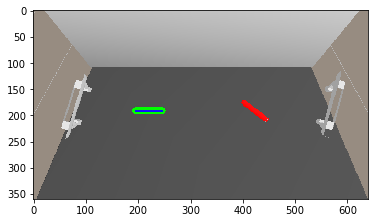

[-4.46524337e-08  0.00000000e+00  2.18238301e-03] [-2.0460402e-05  0.0000000e+00  1.0000000e+00] 1.5707760634326406
setting gripping to true
GRASPED!


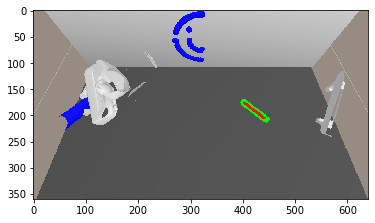

[ 3.58262190e-06  0.00000000e+00 -1.50980073e-03] [ 0.0023729   0.         -0.99999718] 1.5466013510399115
setting gripping to true
GRASPED!


In [4]:
#main function to run everything together
for color in colors:
    selected_arm,capsulestr=select_arm(color)
    grasp_part(selected_arm,capsulestr)
    ImageProducing(color)